# Explanatory Data Analysis & Data Presentation (Movies Dataset)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
pd.options.display.max_colwidth = 200
pd.options.display.max_columns = 30
pd.options.display.float_format = '{:.2f}'.format

## Data Import and first Inspection

1. __Import__ the movies dataset from the CSV file "movies_complete.csv". __Inspect__ the data.

__Some additional information on Features/Columns__:

* **id:** The ID of the movie (clear/unique identifier).
* **title:** The Official Title of the movie.
* **tagline:** The tagline of the movie.
* **release_date:** Theatrical Release Date of the movie.
* **genres:** Genres associated with the movie.
* **belongs_to_collection:** Gives information on the movie series/franchise the particular film belongs to.
* **original_language:** The language in which the movie was originally shot in.
* **budget_musd:** The budget of the movie in million dollars.
* **revenue_musd:** The total revenue of the movie in million dollars.
* **production_companies:** Production companies involved with the making of the movie.
* **production_countries:** Countries where the movie was shot/produced in.
* **vote_count:** The number of votes by users, as counted by TMDB.
* **vote_average:** The average rating of the movie.
* **popularity:** The Popularity Score assigned by TMDB.
* **runtime:** The runtime of the movie in minutes.
* **overview:** A brief blurb of the movie.
* **spoken_languages:** Spoken languages in the film.
* **poster_path:** The URL of the poster image.
* **cast:** (Main) Actors appearing in the movie.
* **cast_size:** number of Actors appearing in the movie.
* **director:** Director of the movie.
* **crew_size:** Size of the film crew (incl. director, excl. actors).

In [2]:
# Read data and parse date column
df = pd.read_csv("./movies_complete.csv", parse_dates=["release_date"])
# Select important columns for analysis
df_main = df[["poster_path", "title", "release_date", "genres", "original_language", "budget_musd", "revenue_musd", 
              "vote_count", "vote_average", "production_companies"]].copy()
# Display movie's poster inside the dataframe
HTML(df_main.iloc[:3, ].to_html(escape=False))


,poster_path,title,release_date,genres,original_language,budget_musd,revenue_musd,vote_count,vote_average,production_companies
0,,Toy Story,1995-10-30,Animation|Comedy|Family,en,30.00,373.55,5415.00,7.70,Pixar Animation Studios
1,,Jumanji,1995-12-15,Adventure|Fantasy|Family,en,65.00,262.80,2413.00,6.90,TriStar Pictures|Teitler Film|Interscope Communications
2,,Grumpier Old Men,1995-12-22,Romance|Comedy,en,NaN,NaN,92.00,6.50,Warner Bros.|Lancaster Gate


In [3]:
# Get column statistic
(df_main.drop(["release_date"], axis=1)).describe()

,budget_musd,revenue_musd,vote_count,vote_average
count,8854.00,7385.00,44691.00,42077.00
mean,21.67,68.97,111.65,6.00
std,34.36,146.61,495.32,1.28
min,0.00,0.00,0.00,0.00
25%,2.00,2.41,3.00,5.30
50%,8.20,16.87,10.00,6.10
75%,25.00,67.64,35.00,6.80
max,380.00,2787.97,14075.00,10.00


The peak values in each column significantly surpass the median, suggesting a right-skewed distribution in the dataset. Relying solely on the mean for analysis might not adequately represent the central tendency of the majority of data points.

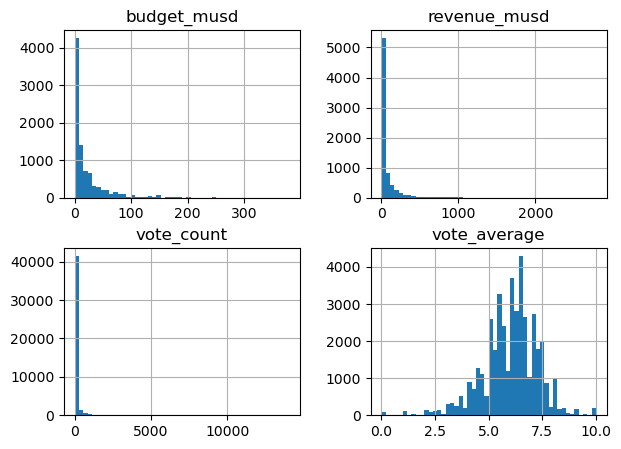

In [4]:
# Visualize numeric column data
df_main.drop(["release_date"], axis=1).hist(figsize=(7, 5), bins=50);

The majority of numeric columns exhibit a right-skewed distribution, with significant outliers on the right side of the distribution.

*Profit Calculation*: Subtract the production cost from the revenue generated by each movie to determine its profit. $$Profit = Revenue - Production Cost$$

*Rate of Return Calculation*: Divide the profit by the production cost and multiply by 100 to obtain the rate of return as a percentage. $$Rate Of Return = \frac{Revenue} {Production Cost} * 100$$

Performing these calculations for each movie in the dataset

In [5]:
# Calculate profit and rate of return 
df_main["profit_musd"] = df_main["revenue_musd"].subtract(df_main["budget_musd"])
df_main["roi"] = df_main["revenue_musd"].div(df_main["budget_musd"])

In [6]:
# Check for missing values
df_main.isnull().sum()

poster_path               224
title                       0
release_date               34
genres                   2105
original_language          10
budget_musd             35837
revenue_musd            37306
vote_count                  0
vote_average             2614
production_companies    11335
profit_musd             39320
roi                     39320
dtype: int64

There are missing values, and depending on future analysis, we will handle missing values differently

## The best and the worst movies...

2. __Filter__ the Dataset and __find the best/worst n Movies__ with the

- Highest Revenue
- Highest Budget
- Highest Profit (=Revenue - Budget)
- Highest Return on Investment (=Revenue / Budget) (only movies with Budget >= 10) 

__Define__ an appropriate __user-defined function__ to reuse code.

In [7]:
def filter_result(col, df=df_main, ascending=True, n_rows=5, col_display=["poster_path", "title"], 
                 filter=[], add_col=[]):
    if len(filter):
        df_temp = df.loc[filter].sort_values(by=col, ascending=ascending)
    else:
        df_temp = df.sort_values(by=col, ascending=ascending)
    if len(add_col):
        column_display = ["poster_path", "title"] + [col] + add_col
    else:
        column_display = ["poster_path", "title"] + [col]
    return HTML(df_temp[column_display].iloc[:n_rows].to_html(escape=False))
    

__Movies Top 5 - Highest Revenue__

In [8]:
# When conducting analyses involving monetary value, it's important to exclude any missing data points.
df_main.dropna(subset=["profit_musd"], inplace=True)
# Top 5 - Highest Revenue
filter_result("revenue_musd", ascending=False)

,poster_path,title,revenue_musd
14448,,Avatar,2787.97
26265,,Star Wars: The Force Awakens,2068.22
1620,,Titanic,1845.03
17669,,The Avengers,1519.56
24812,,Jurassic World,1513.53


In [9]:
# Get the range of year in the dataset
df_main.release_date.apply(lambda x: x.year).max(), df_main.release_date.apply(lambda x: x.year).min()

(2017, 1915)

The dataset includes movies spanning various years from 1874 to 2017, making direct monetary comparisons prone to inflationary effects. To address this, we'll adjust the revenue figures using the US inflation rate. Given that inflation rate data is accessible from 1914 onwards, we'll extrapolate inflation rates for the period between 1874 and 1913 based on historical events. Considering significant economic events like the Long Depression (1873-1879), the Panic of 1893, and the Gold Standard Act of 1900, we assume a -1% inflation rate from 1874 to 1901, reflecting high unemployment rates and numerous bank failures during this period.

The late 19th and early 20th centuries witnessed a surge in industrialization in the United States, resulting in profound economic shifts, urbanization, and the emergence of large corporations, often referred to as trusts. Consequently, we estimate an inflation rate of 1% from 1901 to 1913, aligning closely with historical trends preceding 1914.

$$Real Value = Nominal Value \ast   \prod_i^{n} \left ( 1+\frac{r_i}{100} \right )$$

In [10]:
# Get inflation rate data
df_rate = pd.read_html("https://www.usinflationcalculator.com/inflation/historical-inflation-rates/")
# Save data from the web locally
df_rate[0].to_csv("inflation_rate.csv", index=False)
# Remove irrelevent columns
df_rate = df_rate[0][["Year", "Ave"]]
# Data imputation
imputation = pd.DataFrame({"Year": list(range(1874, 1914)),
                        "Ave": [-0.5 if i < 1901 else 1.0 for i in range(1874, 1914)]})
df_rate = pd.concat([df_rate, imputation], ignore_index=True).sort_values(by="Year").reset_index(drop=True)

In [11]:
# Function to adjust money value to 2017
def inflation_adjust(year, df_rate=df_rate):
    # Filter rate from year of nomial_value to 2017
    df_temp = df_rate.loc[(df_rate["Year"] >= year) & (df_rate["Year"] < 2018), "Ave"] 
    # Convert to percent and add 1
    df_temp = df_temp / 100 + 1
    return np.prod(df_temp)

In [12]:
# Adjust the monetary columns
factor = df_main["release_date"].apply(lambda x: inflation_adjust(x.year))
df_main[["a_budget_musd", "a_revenue_musd", "a_profit_musd", "a_roi"]] = df_main[["budget_musd", "revenue_musd", "profit_musd", "roi"]].multiply(factor, axis=0)

In [13]:
# Top 5 - Highest Adjusted Revenue
filter_result("a_revenue_musd", ascending=False, add_col=["revenue_musd", "release_date", "production_companies"])

,poster_path,title,a_revenue_musd,revenue_musd,release_date,production_companies
884,,Gone with the Wind,6953.28,400.18,1939-12-15,Selznick International Pictures|Metro-Goldwyn-Mayer (MGM)
994,,Alice in Wonderland,5809.63,572.00,1951-07-03,RKO Radio Pictures|Walt Disney Productions
1887,,Bambi,4457.39,267.45,1942-08-14,Walt Disney Productions
255,,Star Wars,3339.33,775.40,1977-05-25,Lucasfilm|Twentieth Century Fox Film Corporation
585,,Snow White and the Seven Dwarfs,3258.95,184.93,1937-12-20,Walt Disney Productions


We obtained entirely different findings when considering adjusted revenue. Among the five movies examined from 1915 to 2917, three are Walt Disney's productions.

__Movies Top 5 - Highest Budget__

In [14]:
filter_result("budget_musd", ascending=False, add_col=["release_date"])

,poster_path,title,budget_musd,release_date
16986,,Pirates of the Caribbean: On Stranger Tides,380.00,2011-05-14
11743,,Pirates of the Caribbean: At World's End,300.00,2007-05-19
26268,,Avengers: Age of Ultron,280.00,2015-04-22
10985,,Superman Returns,270.00,2006-06-28
16006,,Tangled,260.00,2010-11-24


In [15]:
filter_result("a_budget_musd", ascending=False, add_col=["budget_musd", "release_date"])

,poster_path,title,a_budget_musd,budget_musd,release_date
1879,,Metropolis,1282.32,92.62,1927-01-10
1212,,The Manchurian Candidate,655.64,80.00,1962-10-24
16986,,Pirates of the Caribbean: On Stranger Tides,427.48,380.00,2011-05-14
11743,,Pirates of the Caribbean: At World's End,364.42,300.00,2007-05-19
10985,,Superman Returns,338.47,270.00,2006-06-28


Regardless of whether adjustments were made or not, science fiction films consistently emerge as the highest-cost productions.

__Movies Top 5 - Highest Profit__

In [16]:
filter_result("profit_musd", ascending=False, add_col=["release_date"])

,poster_path,title,profit_musd,release_date
14448,,Avatar,2550.97,2009-12-10
26265,,Star Wars: The Force Awakens,1823.22,2015-12-15
1620,,Titanic,1645.03,1997-11-18
24812,,Jurassic World,1363.53,2015-06-09
28501,,Furious 7,1316.25,2015-04-01


In [17]:
filter_result("a_profit_musd", ascending=False, add_col=["profit_musd", "release_date"])

,poster_path,title,a_profit_musd,profit_musd,release_date
884,,Gone with the Wind,6883.78,396.18,1939-12-15
994,,Alice in Wonderland,5779.16,569.00,1951-07-03
1887,,Bambi,4443.09,266.59,1942-08-14
255,,Star Wars,3291.96,764.40,1977-05-25
585,,Snow White and the Seven Dwarfs,3232.72,183.44,1937-12-20


The raw profit figures suggest that science fiction and superhero films typically yield higher profits and draw larger audiences, particularly evident in the 20th century due to advancements in movie effects. However, when considering adjusted profit results, animated movies, predominantly cartoons, emerge as the top earners, likely due to their capacity to showcase impressive visual effects through animation.

__Movies Top 5 - Highest ROI__

In [18]:
filter_result("roi", ascending=False, add_col=["release_date", "budget_musd"])

,poster_path,title,roi,release_date,budget_musd
3965,,Less Than Zero,12396383.00,1987-11-06,0.00
3312,,Modern Times,8500000.00,1936-02-05,0.00
14270,,Welcome to Dongmakgol,4197476.62,2005-08-04,0.00
22041,,Aquí Entre Nos,2755584.00,2012-03-30,0.00
2284,,"The Karate Kid, Part II",1018619.28,1986-06-18,0.00


The exceptionally high rate of return indicates a potential anomaly in the outcome. The ROI is computed by dividing by absent budget values. To ensure reliability, we ought to focus solely on movies with budgets ranking within at least the 25th percentile of the budget column.

In [19]:
# Add threshold of 25 percentile 
budget_threshold = df_main["budget_musd"].describe()["25%"]
filter = df_main["budget_musd"] >= budget_threshold
filter_result("roi", ascending=False, add_col=["release_date", "budget_musd"], filter=filter)

# def filter_result(col, df=df_main, ascending=True, n_rows=5, col_display=["poster_path", "title"], 
#                  filter=None, add_col=[]):

,poster_path,title,roi,release_date,budget_musd
1055,,E.T. the Extra-Terrestrial,75.52,1982-04-03,10.50
255,,Star Wars,70.49,1977-05-25,11.00
1327,,Jaws,67.24,1975-06-18,7.00
1866,,The Exorcist,55.16,1973-12-26,8.00
351,,Four Weddings and a Funeral,42.45,1994-03-09,6.00


Only one of the films ranking highest in terms of return on investment appear on the list of top-profit movies. This observation suggests that films generating high profits often involve substantial investment in captivating effects, leading to increased costs. Achieving a balance between production expenses and maintaining quality content typically yields a better return on investment.

Star Wars: Episode IV - A New Hope, released in 1977 revolutionized the use of special effects in cinema, introducing groundbreaking techniques and technologies that were previously unseen. Consequently, it garnered significant attention from audiences. However, contemporary film effects have evolved to surpass those of Star Wars, becoming more of an industry standard rather than a groundbreaking novelty. Moreover, in today's inflated economy, production costs have escalated, making it increasingly challenging for movies from the 20th century to achieve high rates of return.